In [1]:
#Goal of this analysis is to:
#1 Group reads based on barcode and perform filtering and quality control on barcode groups
#2 Determine Amplicon Sequencing Bias to help adjust primer ratios
#3 Generate Tables of Read Mappings for Each Barcode

#Begin with imports
import timeit
import os
import numpy as np
import pandas as pd
import seaborn as sns
pd.set_option("display.precision", 2) #floats displayed 3 digits
cpallet = ["#6CC860","#8CC860","#C4E54C","#F7DD48","#F5A232","#FC8609","#FE6315"]*3
import matplotlib.pyplot as plot
plot.rcParams['svg.fonttype'] = 'none'
import scipy.stats as stats
from labellines import labelLine, labelLines

header = [] #global var to keep track of the header of the SAM file

#def some classes and basic functions for dealing with the SAM files
class Read (object):
    '''this reads class is specific to SAM files, contains a bunch of attribtues:
ID(barcode), Sequence, Mapping position, Mapping quality, CIGAR string, and FLAG and align'''
    def __init__ (self, ID = "default", seq = "none", MapPos = -1, MapQ = -1, CIGAR = "none", FLAG = "none", align = "none"):
        self.ID = ID
        self.seq = seq
        self.MapPos = MapPos
        self.MapQ = MapQ
        self.CIGAR = CIGAR
        self.FLAG = FLAG
        self.align = align
        self.species = "N/A"
        return
        
    def __str__ (self):
        return "ID: %s \t Seq: %s \t MapPos: %d \t CIGAR: %s \t FLAG: %s \t align: %s" % (self.ID, self.seq, self.MapPos, self.CIGAR, self.FLAG, self.align)

class Bargroup (object):
    def __init__(self, bar = "default", reads = [], species = "undet", num_genes = -1):
        self.bar = bar
        self.reads = reads
        self.species = species
        self.num_genes = num_genes
        return
        

#this function takes the SAM file as input and parses it into a dictionary of barcodes and reads
def in_put1 (infile, limit = 0):      
    bargroups = {}
    count = 0
    
    for line in infile:  #each line is a new read
        if line[0] == "@":        #ignore the line if it is a header
            header.append(line)
            continue       
        
        count += 1        

        split = line.split("\t")    #split line into separate words
        #now assign each segment of the split into a read
        try:
            #read = Read (ID = split[0][:15], align = split[2], seq = split[9], MapPos = int(split[3]), MapQ = split[4], CIGAR = split[5], FLAG = split[1])
            read = Read (ID = split[0], align = split[2], seq = split[9], MapPos = int(split[3]), MapQ = int(split[4]), CIGAR = split[5]) 

        except:
            print( split[3])
            print( "read could not be stored")
        
        if read.ID[:15] in bargroups:
            bargroups[read.ID[:15]].reads.append(read)
        else:
            bargroups[read.ID[:15]] = Bargroup(bar = read.ID, reads = [read])
        
        if limit != 0:
            if count >= limit:
                break
    print( "%d reads inputted" % count)
    return bargroups



In [2]:
#Set paths and get all the SAM files to be analyzed
print(os.getcwd())
samplename = "comm6-summary"
os.chdir("/mnt/scratch/freeman/comm6summary/finaldata")
files = os.listdir(os.getcwd())
files = [f for f in files if f[-4:] == ".sam" and f.find("Unde") == -1]
files.sort()

prefix = [f[:-4] for f in files]
prefix #prefix is used to keep track of samples and for naming files

/home/flan3@ad.wisc.edu/SICMA-analysis/scripts/DoTA-seq/for-paper


['24-1-comm6psg0',
 '24-2-comm6psg0',
 '28-1-psg1erm',
 '28-3-psg1erm',
 '28-6-psg2erm',
 '28-7-psg2erm']

In [12]:
#import the reads into memory usin the in_put function
tic = timeit.default_timer()

libraries = []
for f in files:
    filename = f
    with open(filename, "r") as infile:
        libraries.append(in_put1(infile))
toc = timeit.default_timer()

print(f"it took {toc-tic} seconds")

1467281 reads inputted
1679668 reads inputted
3328139 reads inputted
4762512 reads inputted
2341638 reads inputted
2480943 reads inputted
it took 107.29114546393976 seconds


24-1-comm6psg0.sam the file contains 54542 bargroups
24-2-comm6psg0.sam the file contains 65804 bargroups
28-1-psg1erm.sam the file contains 145458 bargroups
28-3-psg1erm.sam the file contains 212753 bargroups
28-6-psg2erm.sam the file contains 110308 bargroups
28-7-psg2erm.sam the file contains 122567 bargroups


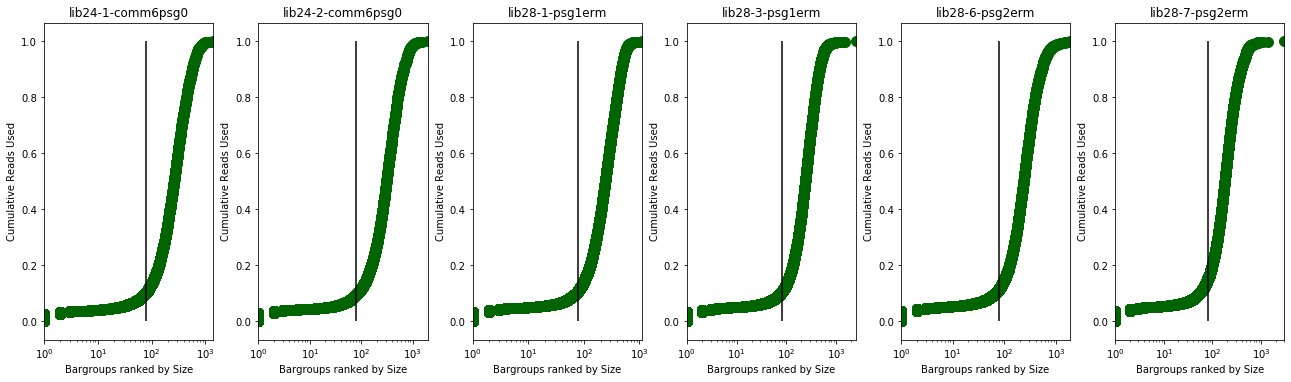

In [13]:
#QC all libraries for how many reads per bargroup, decide which bargroups to keep based on number of reads they contain

#vlines are the cutoffs for removing barcode groups that are too small (too few reads)
#adjust vlines to match the inflection points of each library
vlines = [80, 80, 80, 80, 80, 80]

fig, axs = plot.subplots(1, len(libraries), figsize = [3*len(libraries), 5])
fig.tight_layout()    

#A jackpottocurve is a cumulative histogram of the barcode grouped reads binned by group size (# of reads per group)
def jackpottocurve(fig, ax, barsize, vline):         
        #prepare data to plot the jackpottocurve
        X = np.array(barsize) #make an np array of the data so we can use the various np functions
        X.sort()
        X_lorenz = X.cumsum() / X.sum() #turns it into a cumsum percentage (for y-axis)
        X_lorenz = np.insert(X_lorenz, 0, 0) #insert the 0,0 point
        X = np.insert(X, 0, 0) #insert 0,0 point for X as well
    
        ## scatter plot of the jackpottocurve (modificaiton of the lorenz curve)
        ax.scatter(X, X_lorenz, 
                   marker='o', color='darkgreen', s=100) #x axis is cumulative barcode number, yaxis is cumulative total # reads
        ax.set_title(f"lib{prefix[i]}")
        ax.set_xlim((1,max(barsize)))
        ax.set_xscale("log", basex=10)
        ax.set_xlabel("Bargroups ranked by Size")
        ax.set_ylabel("Cumulative Reads Used")
        ax.vlines(vline, 0, 1)
        return


for i in range(len(libraries)):
    #confirm how many bargroups there are
    print(f"{files[i]} the file contains {len(libraries[i])} bargroups")
    
    #let's now plot the bargroup sizes
    #first obtain the list of bargroup sizes
    barsize = []
    lib = libraries[i]
    for b in lib:
        barsize.append(len(lib[b].reads))
    #plot them on the figure
    ax = axs[i]
    jackpottocurve(fig, ax, barsize, vlines[i])



In [14]:
#now let's filter out the barcodes with specified cutoff # of reads (vlines)
def filter_bar(groups, cutoff):
    filtered_groups = {}
    deleted = 0
    for key in groups:
        if len(groups[key].reads) >= cutoff:
            filtered_groups[key] = groups[key]
        else:
            deleted += 1
    print(f"{deleted} groups removed, {len(filtered_groups)} groups kept, cutoff is {cutoff}")
    return filtered_groups

filtered_libraries = []
for i in range(len(libraries)):
    print(f"library {files[i]}")
    filtered_libraries.append(filter_bar(libraries[i], vlines[i]))



library 24-1-comm6psg0.sam
49112 groups removed, 5430 groups kept, cutoff is 80
library 24-2-comm6psg0.sam
60304 groups removed, 5500 groups kept, cutoff is 80
library 28-1-psg1erm.sam
132387 groups removed, 13071 groups kept, cutoff is 80
library 28-3-psg1erm.sam
193782 groups removed, 18971 groups kept, cutoff is 80
library 28-6-psg2erm.sam
101145 groups removed, 9163 groups kept, cutoff is 80
library 28-7-psg2erm.sam
111115 groups removed, 11452 groups kept, cutoff is 80


In [15]:
#turn the grouped reads into a pandas dataframe

#datastructure as such: rows = each barcode, columns = # reads for each target
dfs = []
for i in range(len(libraries)):
    groups = filtered_libraries[i]
    rowlist = []
    keylist = []
    mappednames = set()
    for b in groups:
        keylist.append(b)
        row = {}
        for r in groups[b].reads:
            if r.align in row:
                row[r.align] += 1
            else:
                row[r.align] = 1
        rowlist.append(row)
        
    df = pd.DataFrame(rowlist, index = keylist)
    df = df.fillna(0) #replace NaN values with 0s
    #fix column headers
    #sort column header
    df = df.reindex(sorted(df.columns), axis=1) #reindex based on sorted new columns
    #fix names
    cols = df.columns.tolist()
    cols = [c if c.find("|") == -1 else c.split("|")[5] for c in cols]
    df.columns = cols    
    #add to the dfs list
    dfs.append(df)    

libraries = None #clear the libraries variable to free up memory
    
dfs[0]



IndexError: list index out of range

In [ ]:
#export dataframe to excel sheet
for i in range(len(prefix)):
    with pd.ExcelWriter(f'{prefix[i]}.xlsx') as writer:  
        dfs[i].to_excel(writer)